<a href="https://colab.research.google.com/github/ojimenezn/geometry-optim/blob/master/optim-emt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Learning-based Geometry Optimization in Molecular Simulation

## Dependencies 

If you are interested in trying DFT instead of EMT, you can uncomment the code below (uses Quantum Espresso). 

In [ ]:
!pip install mpi4py
!git clone https://github.com/ojimenezn/geometry-optim.git
!cd geometry-optim/utils; python libsymf_builder.py
!pip install ase
#!pip install dftbook
#import dftbook
#dftbook.setup_colab()

In [33]:
import numpy as np
import torch 
from ase import io
from ase.build import fcc111, bulk, add_adsorbate, molecule
from ase.data.pubchem import pubchem_atoms_search, pubchem_atoms_conformer_search
from ase.db import connect
from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.utils.eos import EquationOfState
from ase.lattice.cubic import FaceCenteredCubic
from ase.optimize import BFGS
from ase.io.trajectory import Trajectory
from ase.visualize import view 
from ase import units

import sys
import os
import shutil
sys.path.insert(0, 'geometry-optim')
from utils.train_agent_surf_frs import BPNN, Agent, get_scaling
from utils.fp_calculator import set_sym, calculate_fp, db_to_fp
from utils.NN_calc import NN_Calc
from google.colab import drive
drive.mount('/drive')

# Deleting existing folders/data, making them again

if os.path.isdir(f'/drive/My Drive/datasets'):
      shutil.rmtree(f'/drive/My Drive/datasets')
if os.path.isdir(f'/drive/My Drive/datasets/bfgs-logs'):
      shutil.rmtree(f'/drive/My Drive/datasets/bfgs-logs')
if os.path.isdir(f'/drive/My Drive/datasets/bfgs-trajs'):
      shutil.rmtree(f'/drive/My Drive/datasets/bfgs-trajs')
if os.path.isdir(f'/drive/My Drive/3g2-4g4'):
      shutil.rmtree(f'/drive/My Drive/3g2-4g4')

if not os.path.isdir(f'/drive/My Drive/datasets'):
      os.mkdir(f'/drive/My Drive/datasets')
if not os.path.isdir(f'/drive/My Drive/datasets/bfgs-logs'):
      os.mkdir(f'/drive/My Drive/datasets/bfgs-logs')
if not os.path.isdir(f'/drive/My Drive/datasets/bfgs-trajs'):
      os.mkdir(f'/drive/My Drive/datasets/bfgs-trajs')
if not os.path.isdir(f'/drive/My Drive/3g2-4g4'):
      os.mkdir(f'/drive/My Drive/3g2-4g4')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## Initial Configuration Setup 

In [34]:
"""
energies = []
volumes = []
LC = [3.98, 4.03, 4.08, 4.13, 4.18, 4.23]

for a in LC:
    ag_bulk = bulk('Ag', 'fcc', a=a)

    ag_bulk.set_calculator(EMT())

    e = ag_bulk.get_potential_energy()
    energies.append(e)
    volumes.append(ag_bulk.get_volume())

eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
aref=4.08
vref = bulk('Ag', 'fcc', a=aref).get_volume()

lattice_constant = (v0/vref)**(1/3)*aref
"""

slab = fcc111('Au', size=(3, 3, 4), vacuum=10.0)
for i in set(np.random.randint(0, len(slab), size=10)):
    slab[i].symbol = 'Cu'
for i in set(np.random.randint(0, len(slab), size=10)):
    slab[i].symbol = 'Ag'
#const = FixAtoms(indices=range(18))  # fix bottom two layers
#slab.set_constraint(const)
#h = 3
#propylene_oxide = pubchem_atoms_search(cid=6378)
#add_adsorbate(slab, propylene_oxide, h, 'fcc', offset=(1))
slab_copy = slab.copy()
slab_copy.set_calculator(EMT())

db = connect('/drive/My Drive/datasets/to-cal-step0.db')
db.write(slab)

emt_db = connect('/drive/My Drive/datasets/to-cal-step0-emt.db')
#slab.set_calculator(Espresso(pw=500.0, calculation='scf', kpts=(4,4,1), xc='PBE'))
slab.set_calculator(EMT())
slab.get_potential_energy()
emt_db.write(slab)

1

which indicates, as expected, that we have one configuration in the database (initial configuration, shown below). 

In [35]:
view(slab, viewer='x3d')

## Setup (e.g. symmetry functions, NN architecture)



In [36]:
elements = ['Au', 'Cu', 'Ag']

Gs = [2, 4]
cutoff = 6.0
g2_etas = [0.05, 4.0, 20.0, 80.0]
g2_Rses = [0.0]
g4_etas = [0.005]
g4_zetas = [1.0, 4.0]
g4_lambdas = [-1.0, 1.0]

params_set = set_sym(elements, Gs, cutoff, g2_etas=g2_etas, g2_Rses=g2_Rses,
                     g4_etas=g4_etas, g4_zetas=g4_zetas, g4_lambdas=g4_lambdas)

Name = '3g2-4g4'
device = torch.device('cpu')

layer_nodeses = [[20, 20]] * 10
activations = [['tanh', 'tanh']] * 10
lrs = [1] * 10
ensemble_size = 10

## NN Ensemble Optimization 

In [37]:
# surface relaxation using NN ensemble
N_step = 0
while True:
    if N_step == 0:
        curr_train_db = connect(f'/drive/My Drive/datasets/train-step{N_step}.db')
        caled_db = connect(f'/drive/My Drive/datasets/to-cal-step{N_step}-emt.db')
        caled_data = list(caled_db.select())
        # check if converged
        last_convg = []
        m_frs = []
        for entry in caled_db.select():
            max_frs = abs(entry.forces[:]).max()
            m_frs.append(max_frs)
            last_convg.append(max_frs < 0.05)
        print('max forces')
        print(m_frs)
        if np.all(last_convg):
            print('converged')
            break
        else:
            print('not converged')
        # if not converged, continue training and relaxation
        for entry in caled_db.select():
            curr_train_db.write(entry)
    else:
        last_train_db = connect(f'/drive/My Drive/datasets/train-step{N_step-1}.db')
        caled_db = connect(f'/drive/My Drive/datasets/to-cal-step{N_step}-emt.db')
        caled_data = list(caled_db.select())
        # check if converged
        last_convg = []
        m_frs = []
        for entry in caled_db.select():
            max_frs = abs(entry.forces[:]).max()
            m_frs.append(max_frs)
            last_convg.append(max_frs < 0.05)
        print('max forces')
        print(m_frs)
        if np.all(last_convg):
            print('converged')
            break
        else:
            print('not converged')
        # if not converged, continue training and relaxation
        curr_train_db = connect(f'/drive/My Drive/datasets/train-step{N_step}.db')
        for entry in last_train_db.select():
            curr_train_db.write(entry)
        for entry in caled_db.select():
            curr_train_db.write(entry)

    # make fingerprints
    train_data = db_to_fp(curr_train_db, params_set)
    torch.save(train_data, f'/drive/My Drive/{Name}/after-step{N_step}.sav')
    scale_file = f'/drive/My Drive/{Name}/scale-after-step{N_step}.sav'
    scale = get_scaling(train_data)
    torch.save(scale, scale_file)

    train_data = torch.load(f'/drive/My Drive/{Name}/after-step{N_step}.sav')
    valid_data = torch.load(f'/drive/My Drive/{Name}/after-step{N_step}.sav')
    scale_file = f'/drive/My Drive/{Name}/scale-after-step{N_step}.sav'
    scale = torch.load(scale_file)

    # preprocessing
    train_data['b_fp'] = (train_data['b_fp'] - scale['fp_min']) / (scale['fp_max'] - scale['fp_min'] + 1e-10)
    valid_data['b_fp'] = (valid_data['b_fp'] - scale['fp_min']) / (scale['fp_max'] - scale['fp_min'] + 1e-10)
    train_data['b_dfpdX'] /= (scale['fp_max'] - scale['fp_min'] + 1e-10).view(1, 1, -1, 1, 1)
    valid_data['b_dfpdX'] /= (scale['fp_max'] - scale['fp_min'] + 1e-10).view(1, 1, -1, 1, 1)

    for key in train_data.keys():
        train_data[key] = train_data[key].to(device)
        valid_data[key] = valid_data[key].to(device)

    subpath = f'model-after-step{N_step}'
    if not os.path.isdir(f'/drive/My Drive/{Name}/{subpath}'):
        os.mkdir(f'/drive/My Drive/{Name}/{subpath}')
    model_paths = [f'/drive/My Drive/{Name}/{subpath}/model_{m}.sav' for m in range(ensemble_size)]
    log_names = [f'/drive/My Drive/{Name}/{subpath}/log_{m}.txt' for m in range(ensemble_size)]

    print(f'step-{N_step}-training', flush=True)

    # train NN models
    for m in range(ensemble_size):
        print(f'model {m}')
        agent = Agent(train_data=train_data, valid_data=valid_data, model_path=model_paths[m], test_data=None,
                    layer_nodes=layer_nodeses[m], activation=activations[m], lr=lrs[m],
                    max_iter=10, history_size=100, device=device)
        rsts = agent.train(log_name=log_names[m], n_epoch=300, interupt=True, val_interval=1,
                        is_force=True, nrg_convg=1.5, force_convg=5, max_frs_convg=35, nrg_coef=1000, force_coef=50)

    n_fp = len(params_set[elements[0]]['i'])
    models_list = []
    for m in range(ensemble_size):
        model = BPNN(n_fp, layer_nodeses[m], activations[m], len(elements))
        model_path = f'/drive/My Drive/{Name}/{subpath}/model_{m}.sav'
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        models_list.append(model)

    scale = torch.load(f'/drive/My Drive/{Name}/scale-after-step{N_step}.sav')

    # instantiate ASE NN calculator
    nn_calc = NN_Calc(params_set=params_set, models_list=models_list, scale=scale, elements=elements)

    # Start relaxation from last step
    print(f'step-{N_step}-BFGS')
    db = connect(f'/drive/My Drive/datasets/to-cal-step{N_step}-emt.db')
    c = 0
    for entry in db.select():
        c += 1
        atoms = entry.toatoms()
        atoms.set_calculator(nn_calc)

        log_file = f'/drive/My Drive/datasets/bfgs-logs/after-step{N_step}-log-{c}.txt'
        traj_file = f'/drive/My Drive/datasets/bfgs-trajs/after-step{N_step}-traj-{c}.traj'
        if os.path.isfile(log_file):
            os.remove(log_file)
        if os.path.isfile(traj_file):
            os.remove(traj_file)

        if not last_convg[c-1]:
            if N_step <= 2:
                dyn = BFGS(atoms, logfile=log_file, trajectory=traj_file,
                        maxstep=0.01)  # at beginning, use small step size
            else:
                dyn = BFGS(atoms, logfile=log_file, trajectory=traj_file,
                        maxstep=0.04)  # default maxstep 0.04
            dyn.run(fmax=0.05, steps=50)  # relax with a tighter stop criterion

    print(f'step-{N_step}-check-uncertainty')

    # Check uncertainty
    train_stds = []
    for entry in curr_train_db.select():
        image = entry.toatoms()
        image.set_calculator(nn_calc)
        image.get_potential_energy()
        train_stds.append(image.calc.results['free_energy'])
    std_crit = np.max(train_stds)

    db_to_cal = connect(f'/drive/My Drive/datasets/to-cal-step{N_step+1}.db')  
    traj_stds = []
    traj_nrgs = []
    traj_max_frs = []
    traj_ids = []

    for c in range(1, db.count()+1):
        if last_convg[c-1]:
            db_to_cal.write(caled_data[c-1])
            traj_stds.append('cvd')
            traj_nrgs.append('cvd')
            traj_max_frs.append('cvd')
            traj_ids.append('cvd')
            continue
        intrpt = False
        traj = Trajectory(f'/drive/My Drive/datasets/bfgs-trajs/after-step{N_step}-traj-{c}.traj', 'r')  
        traj = list(traj)
        for i in range(1, len(traj)):
            atoms = traj[i]
            m_f = abs(traj[i].calc.results['forces'][:]).max()
            uncertainty = atoms.calc.results['free_energy']

            if uncertainty > 5.0 * std_crit:  # large uncertainty take the maximum std in training set as the threshold
                if i == 1:  # if the first step update makes the uncertainty larger than the threshold
                    traj_stds.append(traj[i].calc.results['free_energy'])
                    traj_nrgs.append(traj[i].calc.results['energy'])
                    traj_max_frs.append(
                        abs(traj[i].calc.results['forces'][:]).max())
                    traj[i].set_constraint(None)
                    db_to_cal.write(traj[i])
                    traj_ids.append(i)
                else:
                    traj_stds.append(traj[i-1].calc.results['free_energy'])
                    traj_nrgs.append(traj[i-1].calc.results['energy'])
                    traj_max_frs.append(
                        abs(traj[i-1].calc.results['forces'][:]).max())
                    traj[i-1].set_constraint(None)
                    db_to_cal.write(traj[i-1])
                    traj_ids.append(i-1)
                intrpt = True
                print('encounter uncertain image')
                break

            elif m_f < 0.04:  # converge with certainty, a little bit tighter for the true convergence criterion since there is error for NN
                traj_stds.append(traj[i].calc.results['free_energy'])
                traj_nrgs.append(traj[i].calc.results['energy'])
                traj_max_frs.append(abs(traj[i].calc.results['forces'][:]).max())
                traj[i].set_constraint(None)
                db_to_cal.write(traj[i])
                traj_ids.append(i)
                intrpt = True
                print('all images are certain, and converged in terms of NN, call EMT for check')
                break

        if not intrpt:  # at the end of the trajectory, the uncertainty is small but not converged in terms of NN
            traj[-1].set_constraint(None)
            db_to_cal.write(traj[-1])
            traj_stds.append('None')
            traj_nrgs.append('None')
            traj_max_frs.append('None')
            traj_ids.append(len(traj)-1)
            print('all images are certain, but not converged in terms of NN, call EMT for training')
        
        # query with EMT
        db_to_cal_emt = connect(f'/drive/My Drive/datasets/to-cal-step{N_step+1}-emt.db')
        for entry in db_to_cal.select():
            atoms = entry.toatoms()
            #atoms.set_calculator(Espresso(pw=500.0, calculation='scf', kpts=(4,4,1), xc='PBE'))
            atoms.set_calculator(EMT())
            atoms.get_potential_energy()
            db_to_cal_emt.write(atoms)
        print('-----------------------------------------------------')
        N_step += 1

max forces
[0.8398243072738439]
not converged
step-0-training
model 0
model 1
model 2
model 3
model 4
model 5
model 6
model 7
model 8
model 9
step-0-BFGS
step-0-check-uncertainty
encounter uncertain image
-----------------------------------------------------
max forces
[0.8331675186559533]
not converged
step-1-training
model 0
model 1
model 2
model 3
model 4
model 5
model 6
model 7
model 8
model 9
step-1-BFGS
step-1-check-uncertainty
encounter uncertain image
-----------------------------------------------------
max forces
[0.8058334180016119]
not converged
step-2-training
model 0
model 1
model 2
model 3
model 4
model 5
model 6
model 7
model 8
model 9
step-2-BFGS
step-2-check-uncertainty
encounter uncertain image
-----------------------------------------------------
max forces
[0.7324089348838316]
not converged
step-3-training
model 0
model 1
model 2
model 3
model 4
model 5
model 6
model 7
model 8
model 9
step-3-BFGS
step-3-check-uncertainty
encounter uncertain image
------------------

In [42]:
cu_rlx = caled_db.get_atoms()
view(cu_rlx, viewer = 'x3d')

In [39]:
print(f'Total number of EMT Queries: {(N_step)}')

Total number of EMT Queries: 9


## EMT Optimization (No Neural Network)

In [41]:
dyn = BFGS(slab_copy, trajectory='/drive/My Drive/datasets/slab-rlx-emt.traj')
dyn.run(fmax=0.05)

      Step     Time          Energy         fmax
BFGS:    0 23:09:20        7.558176        0.8428
BFGS:    1 23:09:20        7.418864        0.8340
BFGS:    2 23:09:21        6.392577        0.9538
BFGS:    3 23:09:21        6.303460        0.5113
BFGS:    4 23:09:21        6.243267        0.5180
BFGS:    5 23:09:21        5.934240        0.6263
BFGS:    6 23:09:21        5.876925        0.4370
BFGS:    7 23:09:21        5.836052        0.3120
BFGS:    8 23:09:21        5.807520        0.2812
BFGS:    9 23:09:21        5.767253        0.1888
BFGS:   10 23:09:21        5.753002        0.1260
BFGS:   11 23:09:22        5.748861        0.1243
BFGS:   12 23:09:22        5.746332        0.1233
BFGS:   13 23:09:22        5.742440        0.0977
BFGS:   14 23:09:22        5.739008        0.0729
BFGS:   15 23:09:22        5.737030        0.0666
BFGS:   16 23:09:22        5.735844        0.0667
BFGS:   17 23:09:22        5.734339        0.0633
BFGS:   18 23:09:22        5.732452        0.0503
B

True

## Trajectory Movie 

In [43]:
initial_traj = Trajectory(f'/drive/My Drive/datasets/bfgs-trajs/after-step0-traj-1.traj', 'a')
for i in range(1, N_step):
  next_traj = Trajectory(f'/drive/My Drive/datasets/bfgs-trajs/after-step{i}-traj-1.traj')
  for atoms in next_traj:
    initial_traj.write(atoms)
initial_traj.close()

Note that we are appending all trajectories of the active learning loop to 'after-step0-traj-1.traj'. 

In [44]:
from ase.io import read, write
import imageio

if os.path.isdir(f'/drive/My Drive/trajectories'):
      shutil.rmtree(f'/drive/My Drive/trajectories')
if not os.path.isdir(f'/drive/My Drive/trajectories'):
      os.mkdir(f'/drive/My Drive/trajectories')

traj = Trajectory(f'/drive/My Drive/datasets/bfgs-trajs/after-step0-traj-1.traj')
filenames = []
for i,atoms in enumerate(traj[-100:]):
    filename = f'/drive/My Drive/trajectories/traj-{i}.png'
    write(filename, atoms, rotation='10z,-80x')
    filenames += [filename]
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/drive/My Drive/trajectories/movie.gif', images,duration=0.05)

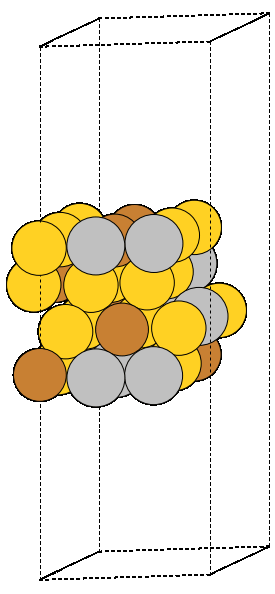

In [45]:
from IPython.display import Image
Image(open('/drive/My Drive/trajectories/movie.gif','rb').read())